## Sprint 深層学習スクラッチ ディープニューラルネットワーク

### 2.ディープニューラルネットワークスクラッチ


前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

#### 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

手を加える箇所

層の数
層の種類（今後畳み込み層など他のタイプの層が登場する）
活性化関数の種類
重みやバイアスの初期化方法
最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

《サンプルコード1》

ScratchDeepNeuralNetrowkClassifierのfitメソッド内

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数

# optimizer = SGD(self.lr)
# self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
# self.activation1 = Tanh()
# self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
# self.activation2 = Tanh()
# self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
# self.activation3 = Softmax()

《サンプルコード2》

イテレーションごとのフォワード

In [53]:
# A1 = self.FC1.forward(X)
# Z1 = self.activation1.forward(A1)
# A2 = self.FC2.forward(Z1)
# Z2 = self.activation2.forward(A2)
# A3 = self.FC3.forward(Z2)
# Z3 = self.activation3.forward(A3)

《サンプルコード3》

イテレーションごとのバックワード

In [54]:
# dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
# dZ2 = self.FC3.backward(dA3)
# dA2 = self.activation2.backward(dZ2)
# dZ1 = self.FC2.backward(dA2)
# dA1 = self.activation1.backward(dZ1)
# dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

#### 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。

以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

《雛形》

In [55]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dW = None
        self.dB = None
        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X.copy()
        A= X @ self.W + self.B
        return  A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        self.dB = np.sum(dA,axis=0) 
        self.dW = self.X.T @ dA
        dZ = dA @ self.W.T #次の層で使う
        # 更新
        self = self.optimizer.update(self)
        return dZ

#### 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

《雛形》

In [112]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W : weight
        """
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B : bias
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

#### 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

雛形

In [57]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #print("dB",layer.dB.shape)
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW
        return 

#### 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。

ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。
$$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$


x
 : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための 
x
 に関する 
f
(
x
)
 の微分は以下のようになります。

 $$
 \frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

数学的には微分可能ではないですが、
 $$
 x
=
0
 のとき 
0
 とすることで対応しています。

フォワード時の 
x
 の正負により、勾配を逆伝播するかどうかが決まるということになります。


In [79]:
class ReLU:
    def __init__(self):
        self.A = None
    def forward(self, X):
        self.A = np.copy(X)
        return np.maximum(0,X)
    def backward(self, X):
        return np.where(self.A>0,X,0)

In [59]:
#シグモイド関数
class Sigmoid:
    def __init__(self):
        self.A = None
    def forward(self,X):
        self.A = 1/(1+np.exp(-1*X))
        return self.A
    def backward(self,X):
        return  X * (1 - self.A)*self.A

In [60]:
#ハイパボリックタンジェント
class Tanh():
    def __init__(self):
        self.A = None
    def forward(self,X):
        self.A = np.tanh(X)
        return self.A
    def backward(self,X):
        return X * (1 - (np.tanh(self.A))**2)

In [61]:
#softmax関数
class Softmax:
    def __init__(self):
        self.b = None
    def forward(self,x):
        self.b = np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)), axis =1, keepdims =True)
        return self.b
    def backward(self,t):
        self.batch = t.shape[0]
        loss = -1/self.batch * np.sum(np.sum(t*np.log(self.b),axis=0))
        dx = (self.b - t) /self.batch
        return dx, loss

#### 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

#### Xavierの初期値
Xavierの初期値における標準偏差 
σ
 は次の式で求められます。
$$
σ
=
1
√
n
$$

n
 : 前の層のノード数

《論文》

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

#### Heの初期値
Heの初期値における標準偏差 
σ
 は次の式で求められます。
$$
σ
=
√
2
n
$$

n
 : 前の層のノード数

《論文》

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [62]:
class XavierInitializer:
    def __init__(self):
        pass
    def W(self, n_nodes1, n_nodes2):
        W = np.random.randn(n_nodes1,n_nodes2) / np.sqrt(n_nodes1)
        return W
    def B(self, n_nodes2):
        B = np.random.randn(n_nodes2)
        return B

In [63]:
class HeInitializer:
    def __init__(self):
        pass
    def W(self, n_nodes1, n_nodes2):
        W = np.random.randn(n_nodes1,n_nodes2) * np.sqrt(2/n_nodes1)
        return W
    def B(self, n_nodes2):
        B = np.random.randn(n_nodes2)
        return B

#### 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

α
 : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$に関する損失 

Lの勾配

& \frac{\partial L}{\partial B_i} &に関する損失 

L
 の勾配

E
(
)
 : ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 
H
 を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

H
i
H
i
 : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

H
′
i
H
i
′
 : 更新した 
H
i
H
i

《論文》

[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)


In [151]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.hb = 0.1
        self.hw = 0.1
    def update(self, layer):
        self.hb +=  (layer.dB) **2 
        self.hw += (layer.dW)**2
        layer.B -= self.lr / np.square(self.hb)*layer.dB
        layer.W -= self.lr / np.square(self.hw)*layer.dW
        return 

#### 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。



In [65]:
from sklearn.metrics import accuracy_score
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [131]:
class ScratchDeepNeuralNetrowkClassifier():    
    def __init__(self,lr=0.01,sigma=0.01,n_node1=400,n_node2=200,n_output=10,verbose=True,epoch=5,batch_size=20,activation="tanh",initial="simple",optimizer="sgd"):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        self.lr = lr
        self.sigma = sigma
        self.n_nodes1 = n_node1
        self.n_nodes2 = n_node2
        self.n_output = n_output
        self.epoch = epoch
        self.verbose = verbose
        self.batch = batch_size
        self.activation = activation
        self.initial = initial
        self.optimizer = optimizer

    def fit(self,X,y,X_val=False,y_val=False):
        get_mini_batch = GetMiniBatch(X, y, self.batch)
        self.n_features = X.shape[1]

        if self.optimizer == "sgd":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        elif self.optimizer == "ada":
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)

        if self.activation == "tanh":
            self.activation1 = Tanh()
            self.activation2= Tanh()
        elif self.activation == "sigmoid":
            self.activation1 = Sigmoid()
            self.activation2= Sigmoid()
        elif self.activation == "relu":
            self.activation1 = ReLU()
            self.activation2= ReLU()

        if self.initial == "simple":
            initial = SimpleInitializer(self.sigma)
        elif self.initial == "xavier":
            initial = XavierInitializer()
        elif self.initial == "he":
            initial = HeInitializer()

        self.FC1 = FC(self.n_features, self.n_nodes1, initial, optimizer1)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initial, optimizer2)
        self.FC3 = FC(self.n_nodes2, self.n_output, initial, optimizer3)
        #3
        self.activation3 = Softmax()

        self.epo_lis = []
        self.loss_lis = []
        self.val_lis = []
        for i in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                Y = (mini_y_train.reshape(-1,1)==np.arange(10)).astype(np.float64)
                self._forward(mini_X_train)
                dA3, loss = self.activation3.backward(Y) # 交差エントロピー誤差とソフトマックスを合わせている
                #print("dA3",dA3.shape)
                dZ2 = self.FC3.backward(dA3)
                #print("dZ2",dA3.shape )
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            self.loss_lis.append(loss)
            #検証
            if X_val is not None:
                y_val_one = (y_val.reshape(-1,1)==np.arange(10)).astype(np.float64)
                y_pre = np.argmax(self._forward(X_val)  ,axis=1)
                accura = accuracy_score(y_val,y_pre)
                self.val_lis.append(self.activation3.backward(y_val_one)[1])
            self.epo_lis.append(i+1)
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print( "epoch",i+1,"loss{:.3f}".format(loss),"accuracy:",accura,"ini",self.initial,"activation",self.activation,"optimizer",self.optimizer)
            pass
    def _forward(self,X):
        #print(X.shape)
        A1 = self.FC1.forward(X)
        #print(A1.shape)
        Z1 = self.activation1.forward(A1)
        #print(Z1.shape)
        A2 = self.FC2.forward(Z1)
        #print(A2.shape)
        Z2 = self.activation2.forward(A2)
        #print(Z2.shape)
        A3 = self.FC3.forward(Z2)
        #print("A3",A3.shape)
        Z3 = self.activation3.forward(A3)        
        #print('Z3',Z3.shape)
        return Z3
    def predict(self,X):

        return np.argmax(self._forward(X),axis=1)

In [121]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [122]:
#前処理
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [69]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10)
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.593 accuracy: 0.8075833333333333 ini simple activation tanh optimizer sgd
epoch 2 loss0.218 accuracy: 0.8828333333333334 ini simple activation tanh optimizer sgd
epoch 3 loss0.166 accuracy: 0.8993333333333333 ini simple activation tanh optimizer sgd
epoch 4 loss0.155 accuracy: 0.9060833333333334 ini simple activation tanh optimizer sgd
epoch 5 loss0.148 accuracy: 0.9125 ini simple activation tanh optimizer sgd
epoch 6 loss0.139 accuracy: 0.9185 ini simple activation tanh optimizer sgd
epoch 7 loss0.130 accuracy: 0.9224166666666667 ini simple activation tanh optimizer sgd
epoch 8 loss0.121 accuracy: 0.9259166666666667 ini simple activation tanh optimizer sgd
epoch 9 loss0.111 accuracy: 0.9289166666666666 ini simple activation tanh optimizer sgd
epoch 10 loss0.101 accuracy: 0.93175 ini simple activation tanh optimizer sgd


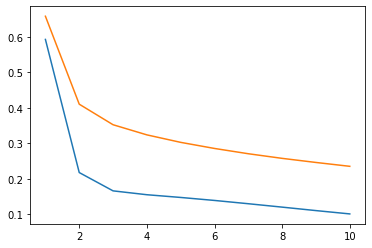

In [70]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [71]:
y_pred = dnn.predict(X_test)
accuracy_score(y_test,y_pred)

0.9342

#### 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [72]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="sigmoid",initial="simple",optimizer="sgd")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss2.371 accuracy: 0.11266666666666666 ini simple activation sigmoid optimizer sgd
epoch 2 loss2.370 accuracy: 0.11266666666666666 ini simple activation sigmoid optimizer sgd
epoch 3 loss2.369 accuracy: 0.11266666666666666 ini simple activation sigmoid optimizer sgd
epoch 4 loss2.367 accuracy: 0.11266666666666666 ini simple activation sigmoid optimizer sgd
epoch 5 loss2.364 accuracy: 0.11266666666666666 ini simple activation sigmoid optimizer sgd
epoch 6 loss2.355 accuracy: 0.11266666666666666 ini simple activation sigmoid optimizer sgd
epoch 7 loss2.294 accuracy: 0.1985 ini simple activation sigmoid optimizer sgd
epoch 8 loss1.907 accuracy: 0.30141666666666667 ini simple activation sigmoid optimizer sgd
epoch 9 loss1.634 accuracy: 0.4514166666666667 ini simple activation sigmoid optimizer sgd
epoch 10 loss1.352 accuracy: 0.543 ini simple activation sigmoid optimizer sgd


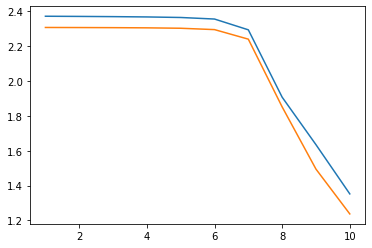

In [73]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [80]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="relu",initial="he",optimizer="sgd")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.160 accuracy: 0.9098333333333334 ini he activation relu optimizer sgd
epoch 2 loss0.112 accuracy: 0.9273333333333333 ini he activation relu optimizer sgd
epoch 3 loss0.083 accuracy: 0.93875 ini he activation relu optimizer sgd
epoch 4 loss0.058 accuracy: 0.9456666666666667 ini he activation relu optimizer sgd
epoch 5 loss0.042 accuracy: 0.9515 ini he activation relu optimizer sgd
epoch 6 loss0.033 accuracy: 0.9553333333333334 ini he activation relu optimizer sgd
epoch 7 loss0.028 accuracy: 0.9581666666666667 ini he activation relu optimizer sgd
epoch 8 loss0.025 accuracy: 0.9615833333333333 ini he activation relu optimizer sgd
epoch 9 loss0.023 accuracy: 0.964 ini he activation relu optimizer sgd
epoch 10 loss0.021 accuracy: 0.96525 ini he activation relu optimizer sgd


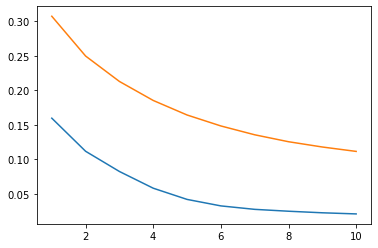

In [81]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [84]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="tanh",initial="xavier",optimizer="sgd")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.216 accuracy: 0.8965833333333333 ini xavier activation tanh optimizer sgd
epoch 2 loss0.148 accuracy: 0.9138333333333334 ini xavier activation tanh optimizer sgd
epoch 3 loss0.123 accuracy: 0.9221666666666667 ini xavier activation tanh optimizer sgd
epoch 4 loss0.106 accuracy: 0.92775 ini xavier activation tanh optimizer sgd
epoch 5 loss0.092 accuracy: 0.9315833333333333 ini xavier activation tanh optimizer sgd
epoch 6 loss0.082 accuracy: 0.9340833333333334 ini xavier activation tanh optimizer sgd
epoch 7 loss0.075 accuracy: 0.9378333333333333 ini xavier activation tanh optimizer sgd
epoch 8 loss0.069 accuracy: 0.94075 ini xavier activation tanh optimizer sgd
epoch 9 loss0.065 accuracy: 0.94475 ini xavier activation tanh optimizer sgd
epoch 10 loss0.061 accuracy: 0.9475 ini xavier activation tanh optimizer sgd


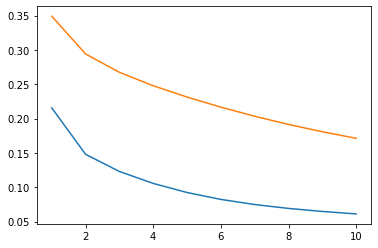

In [85]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [128]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="tanh",initial="simple",optimizer="ada")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.657 accuracy: 0.799 ini simple activation tanh optimizer ada
epoch 2 loss0.254 accuracy: 0.8711666666666666 ini simple activation tanh optimizer ada
epoch 3 loss0.185 accuracy: 0.8925 ini simple activation tanh optimizer ada
epoch 4 loss0.164 accuracy: 0.9003333333333333 ini simple activation tanh optimizer ada
epoch 5 loss0.155 accuracy: 0.9055 ini simple activation tanh optimizer ada
epoch 6 loss0.149 accuracy: 0.90925 ini simple activation tanh optimizer ada
epoch 7 loss0.144 accuracy: 0.9120833333333334 ini simple activation tanh optimizer ada
epoch 8 loss0.139 accuracy: 0.9143333333333333 ini simple activation tanh optimizer ada
epoch 9 loss0.135 accuracy: 0.9171666666666667 ini simple activation tanh optimizer ada
epoch 10 loss0.131 accuracy: 0.9190833333333334 ini simple activation tanh optimizer ada


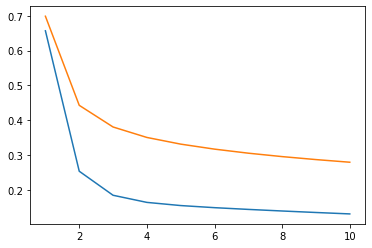

In [129]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [132]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="tanh",initial="xavier",optimizer="ada")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.247 accuracy: 0.8924166666666666 ini xavier activation tanh optimizer ada
epoch 2 loss0.167 accuracy: 0.9080833333333334 ini xavier activation tanh optimizer ada
epoch 3 loss0.140 accuracy: 0.91675 ini xavier activation tanh optimizer ada
epoch 4 loss0.125 accuracy: 0.9213333333333333 ini xavier activation tanh optimizer ada
epoch 5 loss0.115 accuracy: 0.9238333333333333 ini xavier activation tanh optimizer ada
epoch 6 loss0.107 accuracy: 0.9265833333333333 ini xavier activation tanh optimizer ada
epoch 7 loss0.101 accuracy: 0.9288333333333333 ini xavier activation tanh optimizer ada
epoch 8 loss0.096 accuracy: 0.9314166666666667 ini xavier activation tanh optimizer ada
epoch 9 loss0.092 accuracy: 0.9328333333333333 ini xavier activation tanh optimizer ada
epoch 10 loss0.088 accuracy: 0.9344166666666667 ini xavier activation tanh optimizer ada


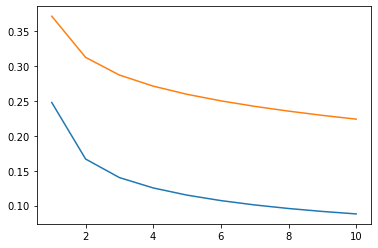

In [133]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [134]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="relu",initial="he",optimizer="ada")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.203 accuracy: 0.902 ini he activation relu optimizer ada
epoch 2 loss0.149 accuracy: 0.9203333333333333 ini he activation relu optimizer ada
epoch 3 loss0.123 accuracy: 0.9275833333333333 ini he activation relu optimizer ada
epoch 4 loss0.106 accuracy: 0.9336666666666666 ini he activation relu optimizer ada
epoch 5 loss0.094 accuracy: 0.9375 ini he activation relu optimizer ada
epoch 6 loss0.086 accuracy: 0.9410833333333334 ini he activation relu optimizer ada
epoch 7 loss0.078 accuracy: 0.9444166666666667 ini he activation relu optimizer ada
epoch 8 loss0.071 accuracy: 0.94725 ini he activation relu optimizer ada
epoch 9 loss0.066 accuracy: 0.9495833333333333 ini he activation relu optimizer ada
epoch 10 loss0.061 accuracy: 0.951 ini he activation relu optimizer ada


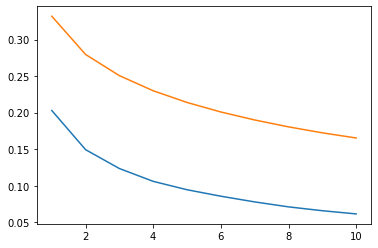

In [135]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)

In [152]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=10,activation="relu",initial="xavier",optimizer="ada")
dnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.016 accuracy: 0.9600833333333333 ini xavier activation relu optimizer ada
epoch 2 loss0.012 accuracy: 0.972 ini xavier activation relu optimizer ada
epoch 3 loss0.005 accuracy: 0.9749166666666667 ini xavier activation relu optimizer ada
epoch 4 loss0.004 accuracy: 0.9766666666666667 ini xavier activation relu optimizer ada
epoch 5 loss0.003 accuracy: 0.97725 ini xavier activation relu optimizer ada
epoch 6 loss0.002 accuracy: 0.9779166666666667 ini xavier activation relu optimizer ada
epoch 7 loss0.001 accuracy: 0.9784166666666667 ini xavier activation relu optimizer ada
epoch 8 loss0.001 accuracy: 0.9790833333333333 ini xavier activation relu optimizer ada
epoch 9 loss0.000 accuracy: 0.9795 ini xavier activation relu optimizer ada
epoch 10 loss0.000 accuracy: 0.97925 ini xavier activation relu optimizer ada


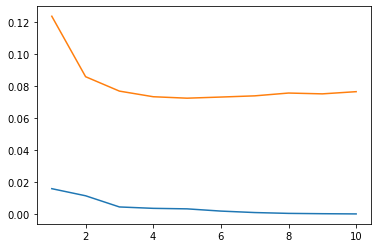

In [153]:
plt.plot(dnn.epo_lis,dnn.loss_lis)
plt.plot(dnn.epo_lis,dnn.val_lis)